**MODULE 1: Data Loading and Preprocessing**

In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.feature_selection import f_regression
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import shapiro
import re
import warnings
warnings.filterwarnings('ignore')

print("=== Flight Delay Regression Analysis ===\n")

# Load and preprocess data
print("Step 1: Data Loading and Preprocessing")
print("Loading data...")
data = pd.read_csv("D://123.csv")
print(f"Data shape: {data.shape}")

# Select relevant columns
df = data[['DEP_DELAY','DEP_DEL15','CANCELLED','CRS_DEP_DATETIME','HourlyAltimeterSetting',
          'HourlyDewPointTemperature','HourlyDryBulbTemperature','HourlyPrecipitation',
          'HourlyPresentWeatherType','HourlyPressureChange','HourlyPressureTendency',
          'HourlyRelativeHumidity','HourlySkyConditions','HourlySeaLevelPressure',
          'HourlyVisibility','HourlyWindDirection','HourlyWindGustSpeed','HourlyWindSpeed',
          'time_diff_min', 'ORIGIN_STATE_NM']]

print(f"Selected data shape: {df.shape}")

# Remove rows with missing DEP_DELAY and time_diff_min
df = df.dropna(subset=['DEP_DELAY','time_diff_min'])
print(f"Data after removing missing DEP_DELAY and time_diff_min: {df.shape}")

# Remove cancelled flights
df = df[df['CANCELLED'] != 1]
df = df.drop(columns=['CANCELLED'])
print(f"Data after removing cancelled flights: {df.shape}")

# Remove rows with missing key weather variables
df = df.dropna(subset=['HourlyDewPointTemperature','HourlyRelativeHumidity','HourlyWindSpeed'])
print(f"Final data shape: {df.shape}")

print(f"Number of delayed flights (DEP_DEL15): {df['DEP_DEL15'].sum()}")
print(f"Delay rate: {df['DEP_DEL15'].sum()/len(df):.4f}")

=== Flight Delay Regression Analysis ===

Step 1: Data Loading and Preprocessing
Loading data...
Data shape: (183170, 49)
Selected data shape: (183170, 20)
Data after removing missing DEP_DELAY and time_diff_min: (179098, 20)
Data after removing cancelled flights: (179002, 19)
Final data shape: (178939, 19)
Number of delayed flights (DEP_DEL15): 34310.0
Delay rate: 0.1917


**MODULE 2: Feature Processing**

In [2]:

print("\nStep 2: Feature Engineering")
print("Engineering features...")

# Cloud type encoding
cloud_types = ["OVC", "BKN", "SCT", "CLR"]

def count_cloud_types(s):
    if pd.isna(s):
        return pd.Series({c: 0 for c in cloud_types})
    counts = {}
    for c in cloud_types:
        counts[c] = len(re.findall(r'\b{}\b'.format(c), str(s)))
    return pd.Series(counts)

cloud_counts = df["HourlySkyConditions"].apply(count_cloud_types)
df = pd.concat([df, cloud_counts], axis=1)

# Weather type encoding
weather_types = ["RA", "SN", "DZ", "FZRA", "PL", "TS", "FG", "BR"]

def encode_weather(s):
    if pd.isna(s):
        return pd.Series({w: 0 for w in weather_types})
    s = str(s).upper()
    result = {}
    for w in weather_types:
        result[w] = 0
        matches = re.findall(r'([+-]?){0}(:\d+)?'.format(w), s)
        if matches:
            for m in matches:
                prefix = m[0]
                if prefix == '+':
                    val = 1
                elif prefix == '-':
                    val = -1
                else:
                    val = 0
                result[w] = max(result[w], val)
    return pd.Series(result)

weather_encoded = df["HourlyPresentWeatherType"].apply(encode_weather)
df = pd.concat([df, weather_encoded], axis=1)

# Handle precipitation (convert 'T' to 0)
df["HourlyPrecipitation"] = df["HourlyPrecipitation"].replace("T", 0).astype(float)

# Prepare features and target for regression
print("Preparing features for regression...")

# Select features for regression
feature_columns = ['HourlyAltimeterSetting', 'HourlyDewPointTemperature', 
                  'HourlyDryBulbTemperature', 'HourlyPrecipitation',
                  'HourlyPressureChange', 'HourlyPressureTendency',
                  'HourlyRelativeHumidity', 'HourlySeaLevelPressure', 
                  'HourlyVisibility', 'HourlyWindGustSpeed', 'HourlyWindSpeed',
                  'time_diff_min']

# Remove rows with missing values in selected features
df_reg = df[['DEP_DELAY'] + feature_columns + ['ORIGIN_STATE_NM']].copy()
df_reg = df_reg.dropna()
print(f"Data for regression after removing missing values: {df_reg.shape}")

X = df_reg[feature_columns]
y = df_reg['DEP_DELAY']  # Target variable: flight delay time

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")


Step 2: Feature Engineering
Engineering features...
Preparing features for regression...
Data for regression after removing missing values: (4613, 14)
Features shape: (4613, 12)
Target shape: (4613,)


**MODULE 3: Data Normalization and Complete Univariate Analysis**


Step 3: Data Normalization and Complete Univariate Analysis
1. Data Normalization
Data normalization completed

2. Complete Univariate Analysis - All Input Variables
2.1 Statistical Summary of All Input Variables

Statistical Summary of All Normalized Input Variables:
       HourlyAltimeterSetting  HourlyDewPointTemperature  \
count               4613.0000                  4613.0000   
mean                   0.0000                     0.0000   
std                    1.0001                     1.0001   
min                   -3.2805                    -2.9514   
25%                   -0.6379                    -0.8422   
50%                    0.0262                     0.1574   
75%                    0.6480                     0.8272   
max                    3.8134                     1.7768   

       HourlyDryBulbTemperature  HourlyPrecipitation  HourlyPressureChange  \
count                 4613.0000            4613.0000             4613.0000   
mean                    -0.0000  

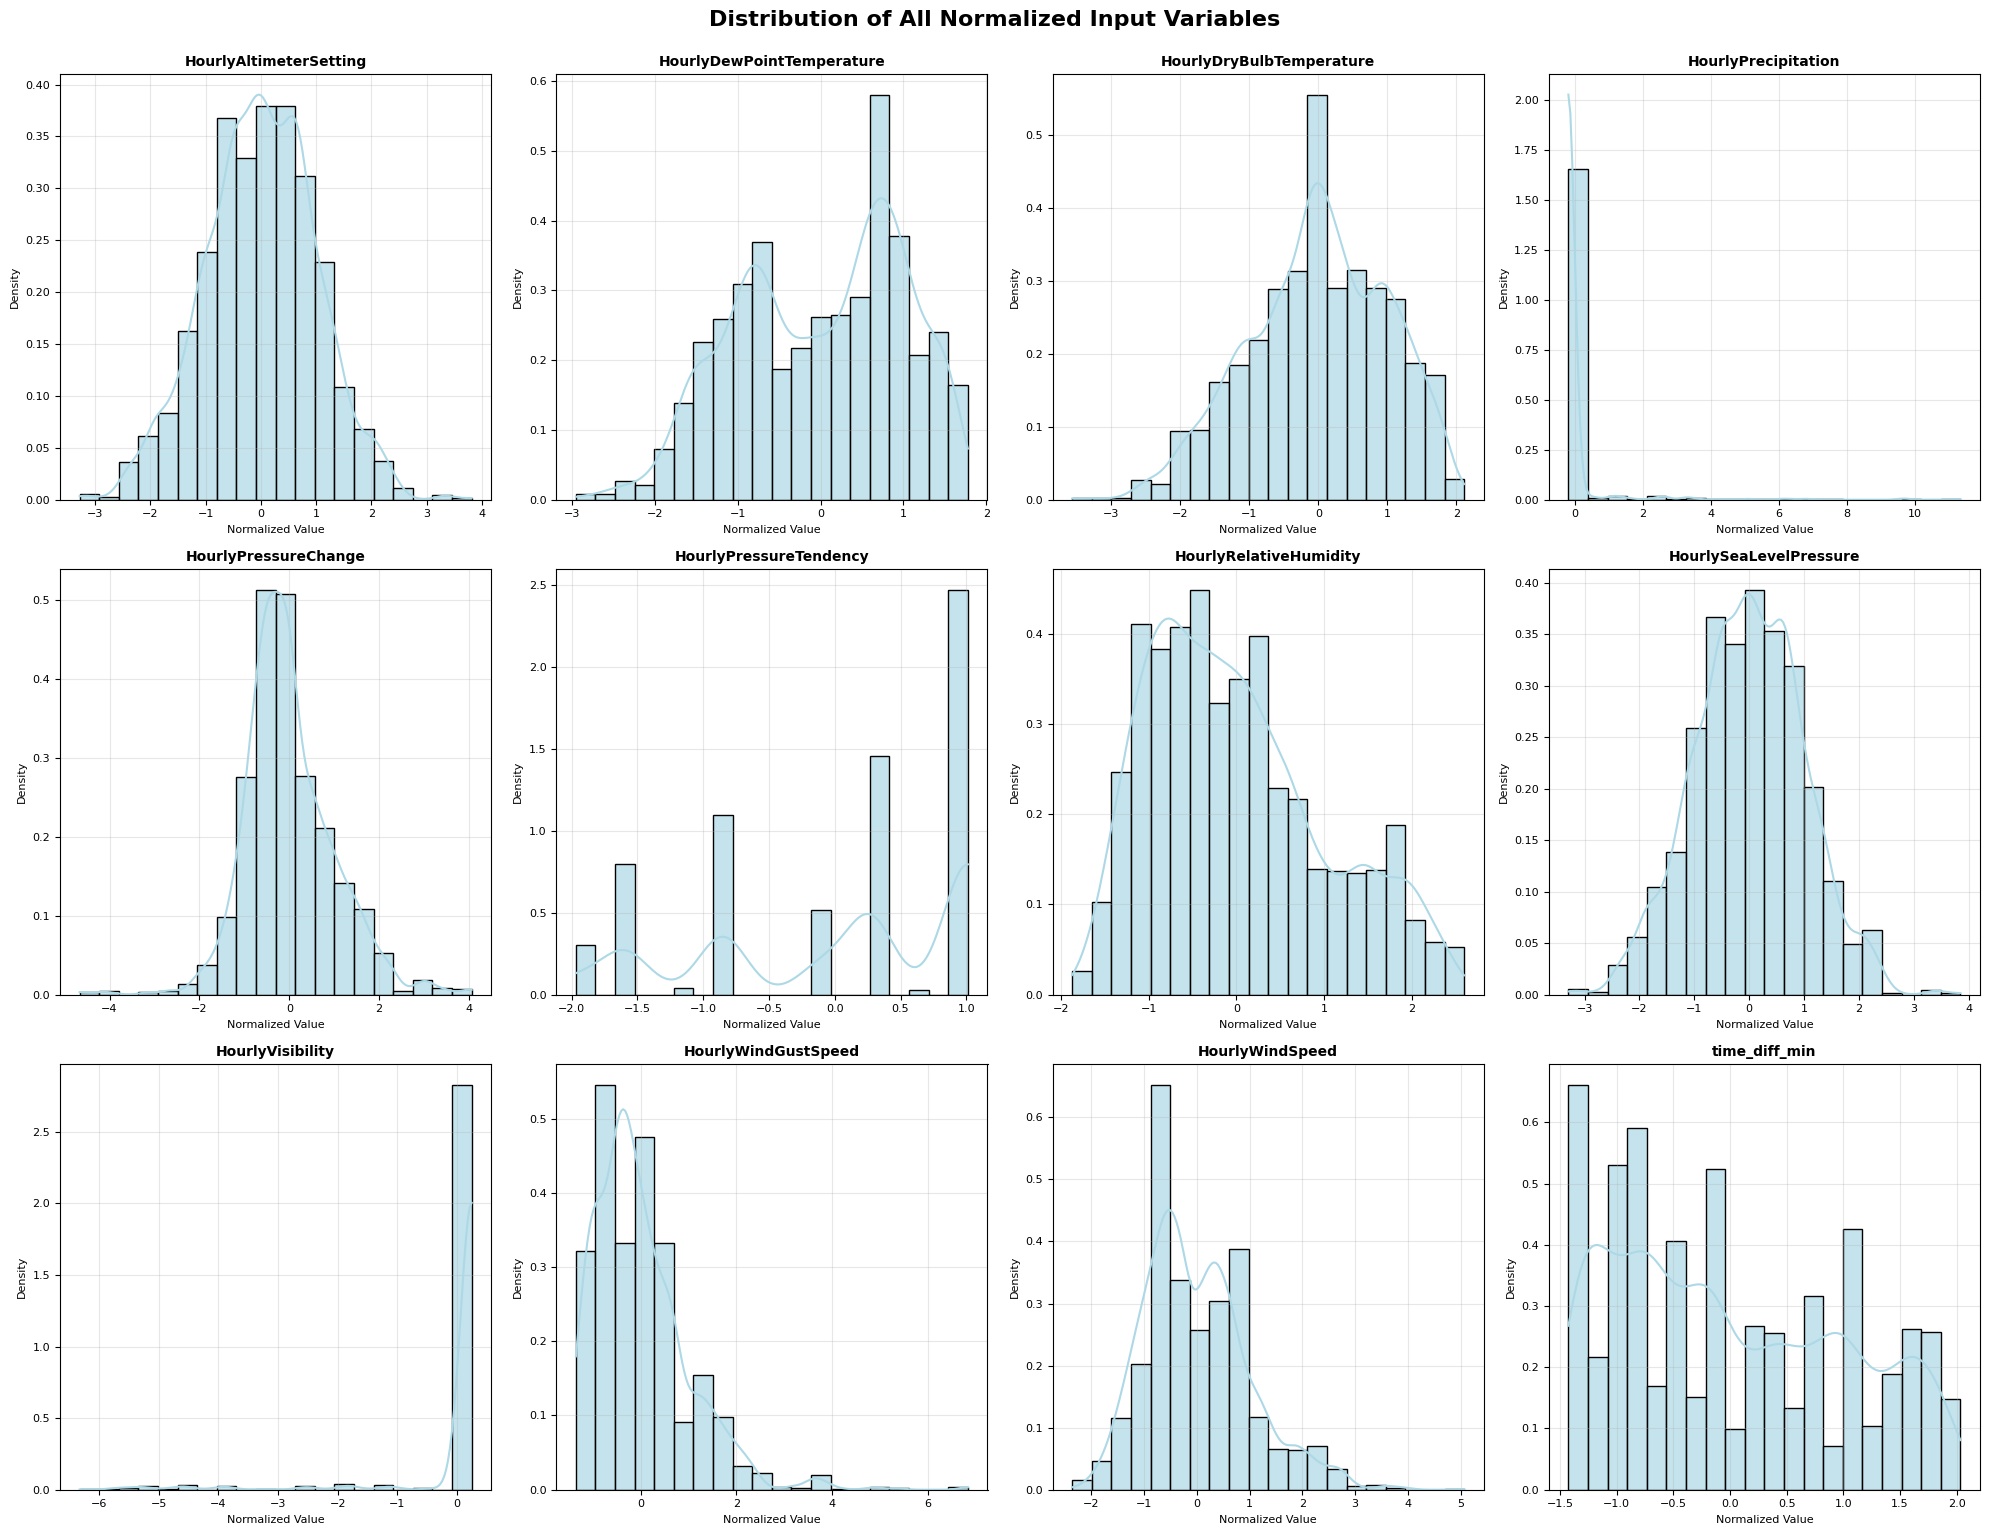


2.3 Box Plots for All Variables - Outlier Detection


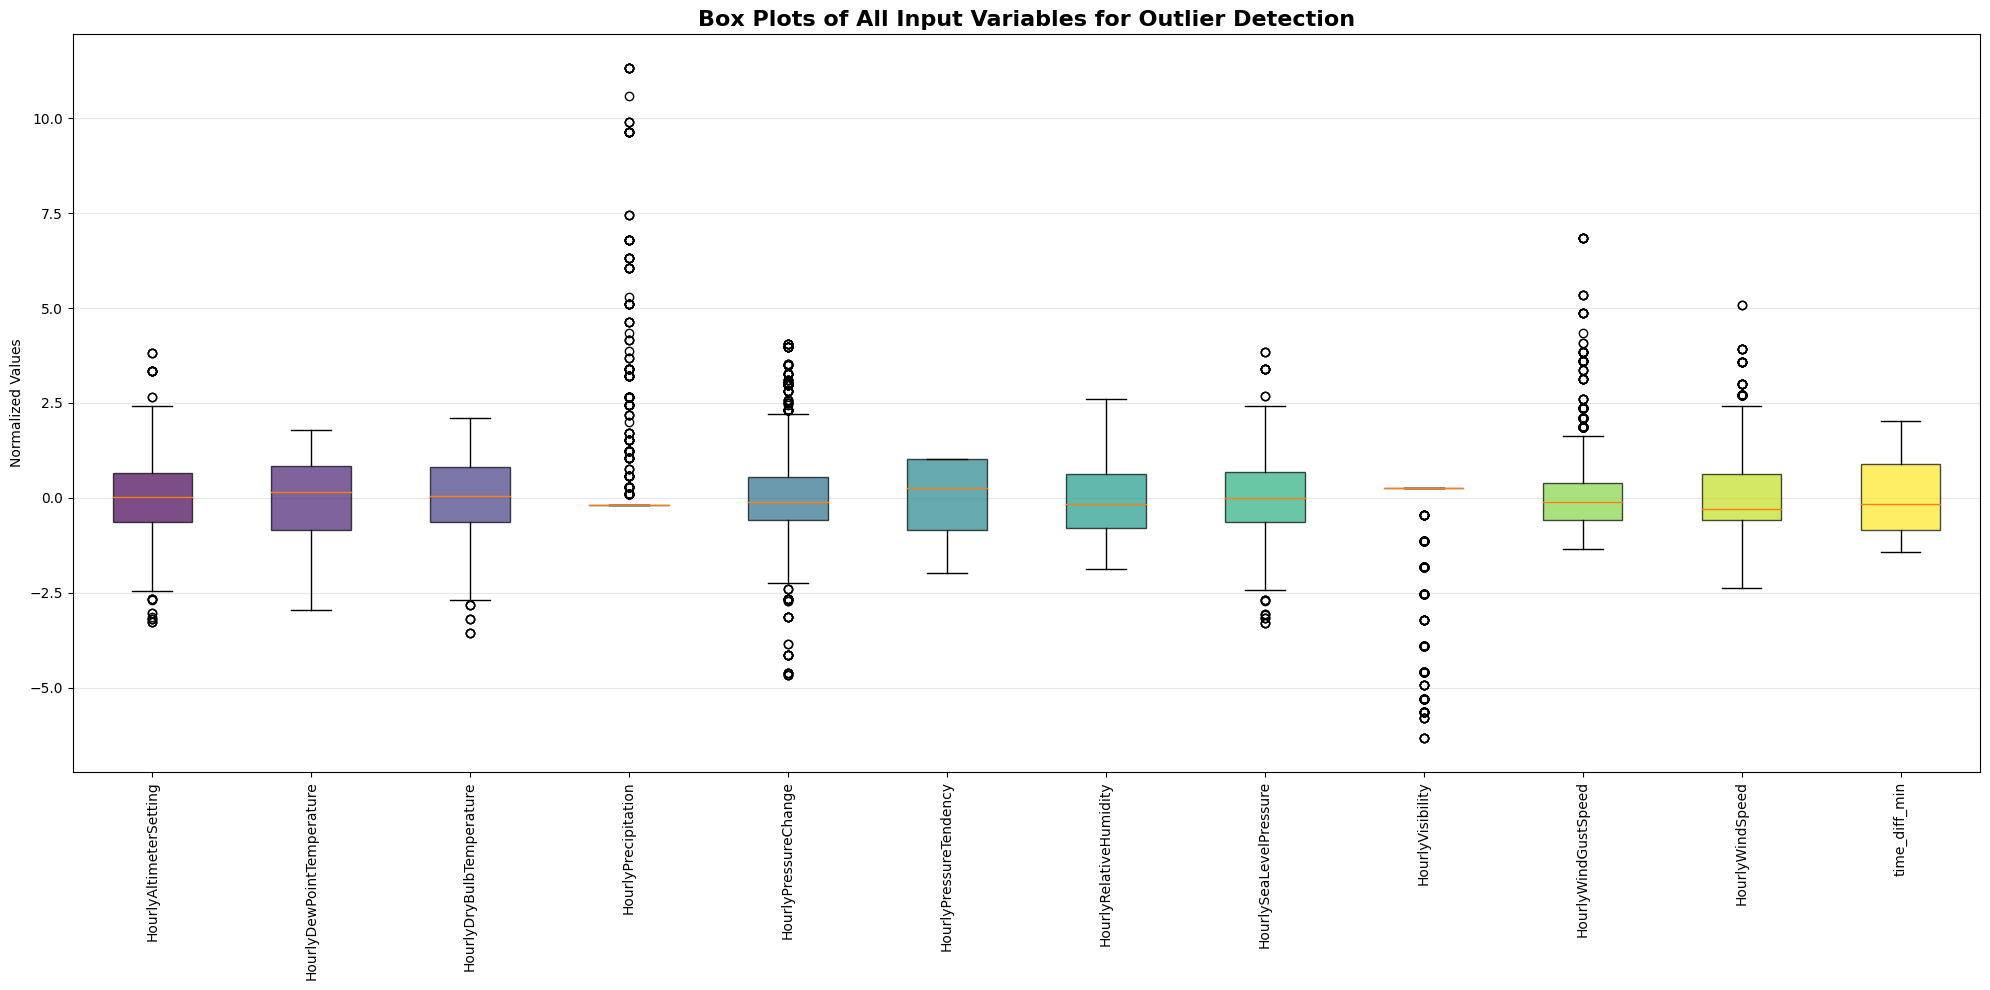

In [4]:

print("\nStep 3: Data Normalization and Complete Univariate Analysis")

# Data Normalization
print("1. Data Normalization")
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)
X_normalized_df = pd.DataFrame(X_normalized, columns=feature_columns, index=X.index)
print("Data normalization completed")

# Create comprehensive univariate analysis
print("\n2. Complete Univariate Analysis - All Input Variables")

# 2.1 Statistical summary of all variables
print("2.1 Statistical Summary of All Input Variables")
stat_summary_all = X_normalized_df.describe()
print("\nStatistical Summary of All Normalized Input Variables:")
print(stat_summary_all.round(4))

# 2.2 Distribution histograms for all variables
print("\n2.2 Distribution Histograms for All Variables")

# Create multiple subplots to display distributions of all variables
n_features = len(feature_columns)
n_cols = 4
n_rows = (n_features + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5*n_rows))
axes = axes.flatten()

for i, feature in enumerate(feature_columns):
    ax = axes[i]
    
    # Create histogram with density curve
    sns.histplot(X_normalized_df[feature], kde=True, stat="density", bins=20, ax=ax, 
                 color='lightblue', alpha=0.7, edgecolor='black')
    
    ax.set_title(f'{feature}', fontsize=10, fontweight='bold')
    ax.set_xlabel('Normalized Value', fontsize=8)
    ax.set_ylabel('Density', fontsize=8)
    ax.grid(True, alpha=0.3)
    ax.tick_params(axis='both', which='major', labelsize=8)

# Hide excess subplots
for i in range(n_features, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.suptitle('Distribution of All Normalized Input Variables', 
             fontsize=16, fontweight='bold', y=1.02)
plt.show()

# 2.3 Box plots for all variables (outlier detection)
print("\n2.3 Box Plots for All Variables - Outlier Detection")

plt.figure(figsize=(20, 10))
box_data = [X_normalized_df[feature] for feature in feature_columns]

# Create box plots
box_plot = plt.boxplot(box_data, labels=feature_columns, patch_artist=True)

# Color the box plots
colors = plt.cm.viridis(np.linspace(0, 1, len(box_data)))
for patch, color in zip(box_plot['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

plt.title('Box Plots of All Input Variables for Outlier Detection', 
          fontsize=16, fontweight='bold')
plt.ylabel('Normalized Values')
plt.xticks(rotation=90)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()



**MODULE 4: Multivariate Analysis and Correlation Analysis**


Step 4: Complete Multivariate Analysis and Correlation Analysis
4.1 Creating Complete Pairwise Relationships with All Variables
Creating PairGrid visualization with all variables...


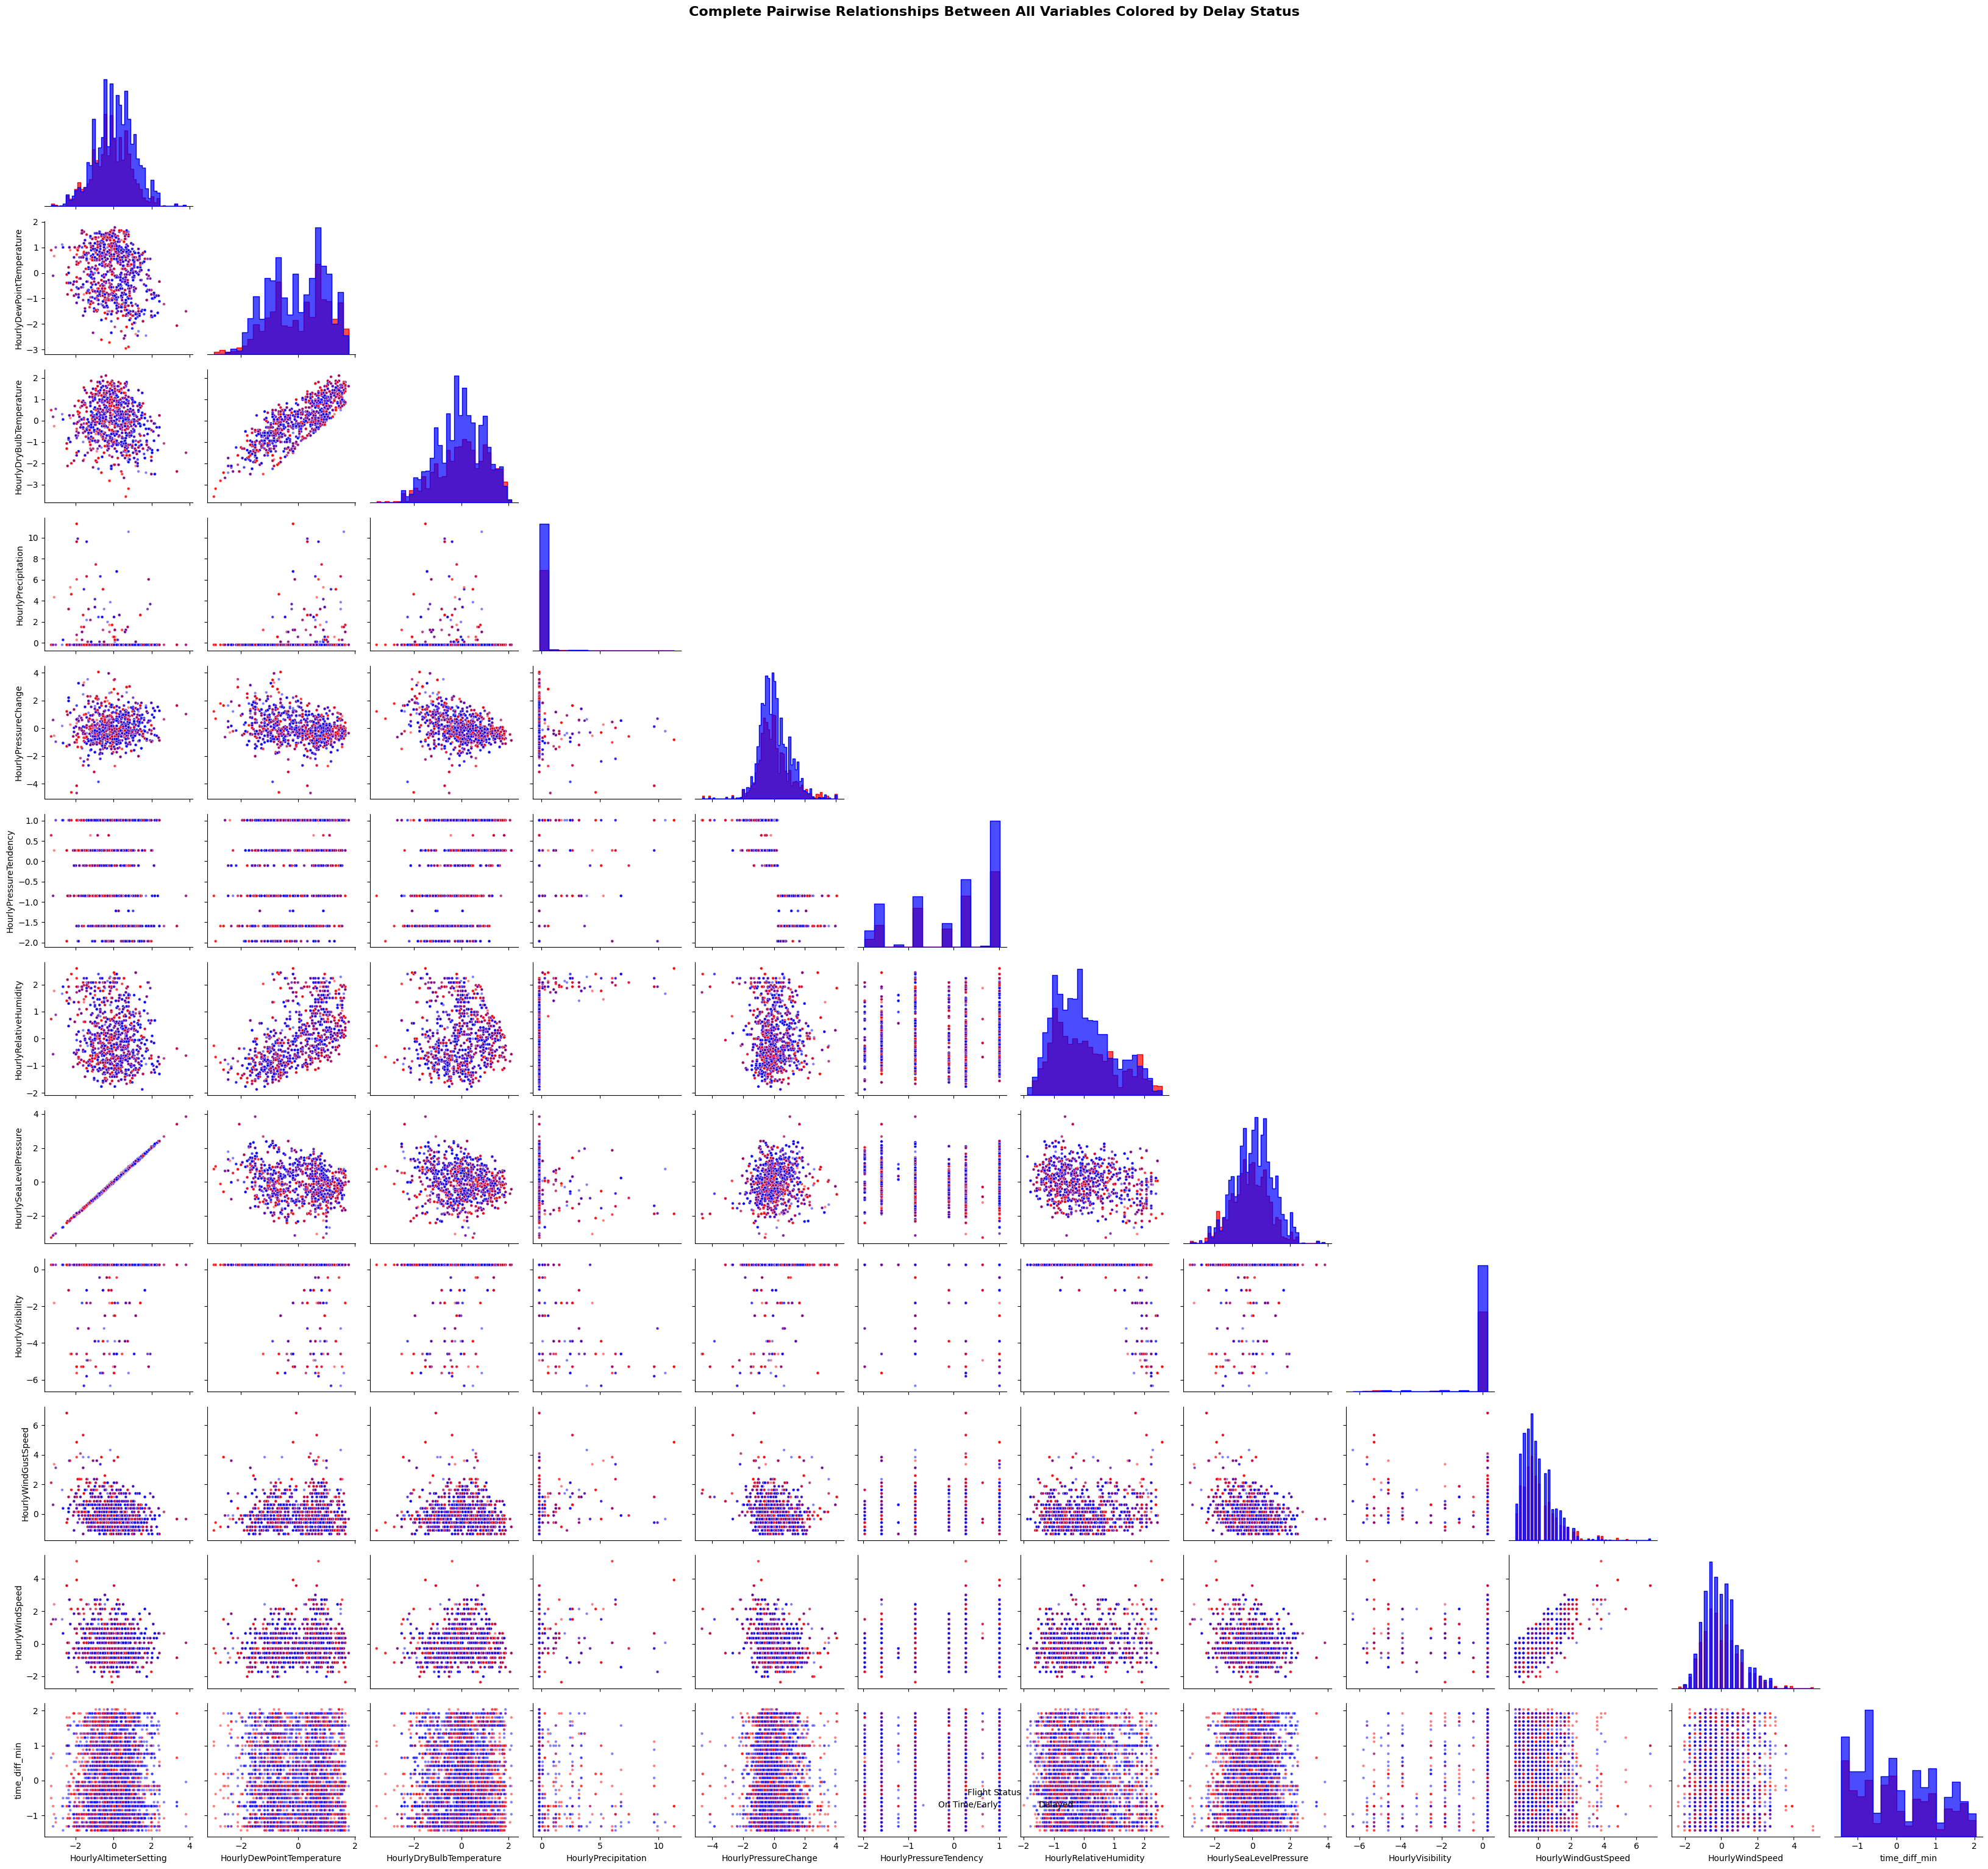


4.2 Creating Complete Correlation Heatmap with All Variables


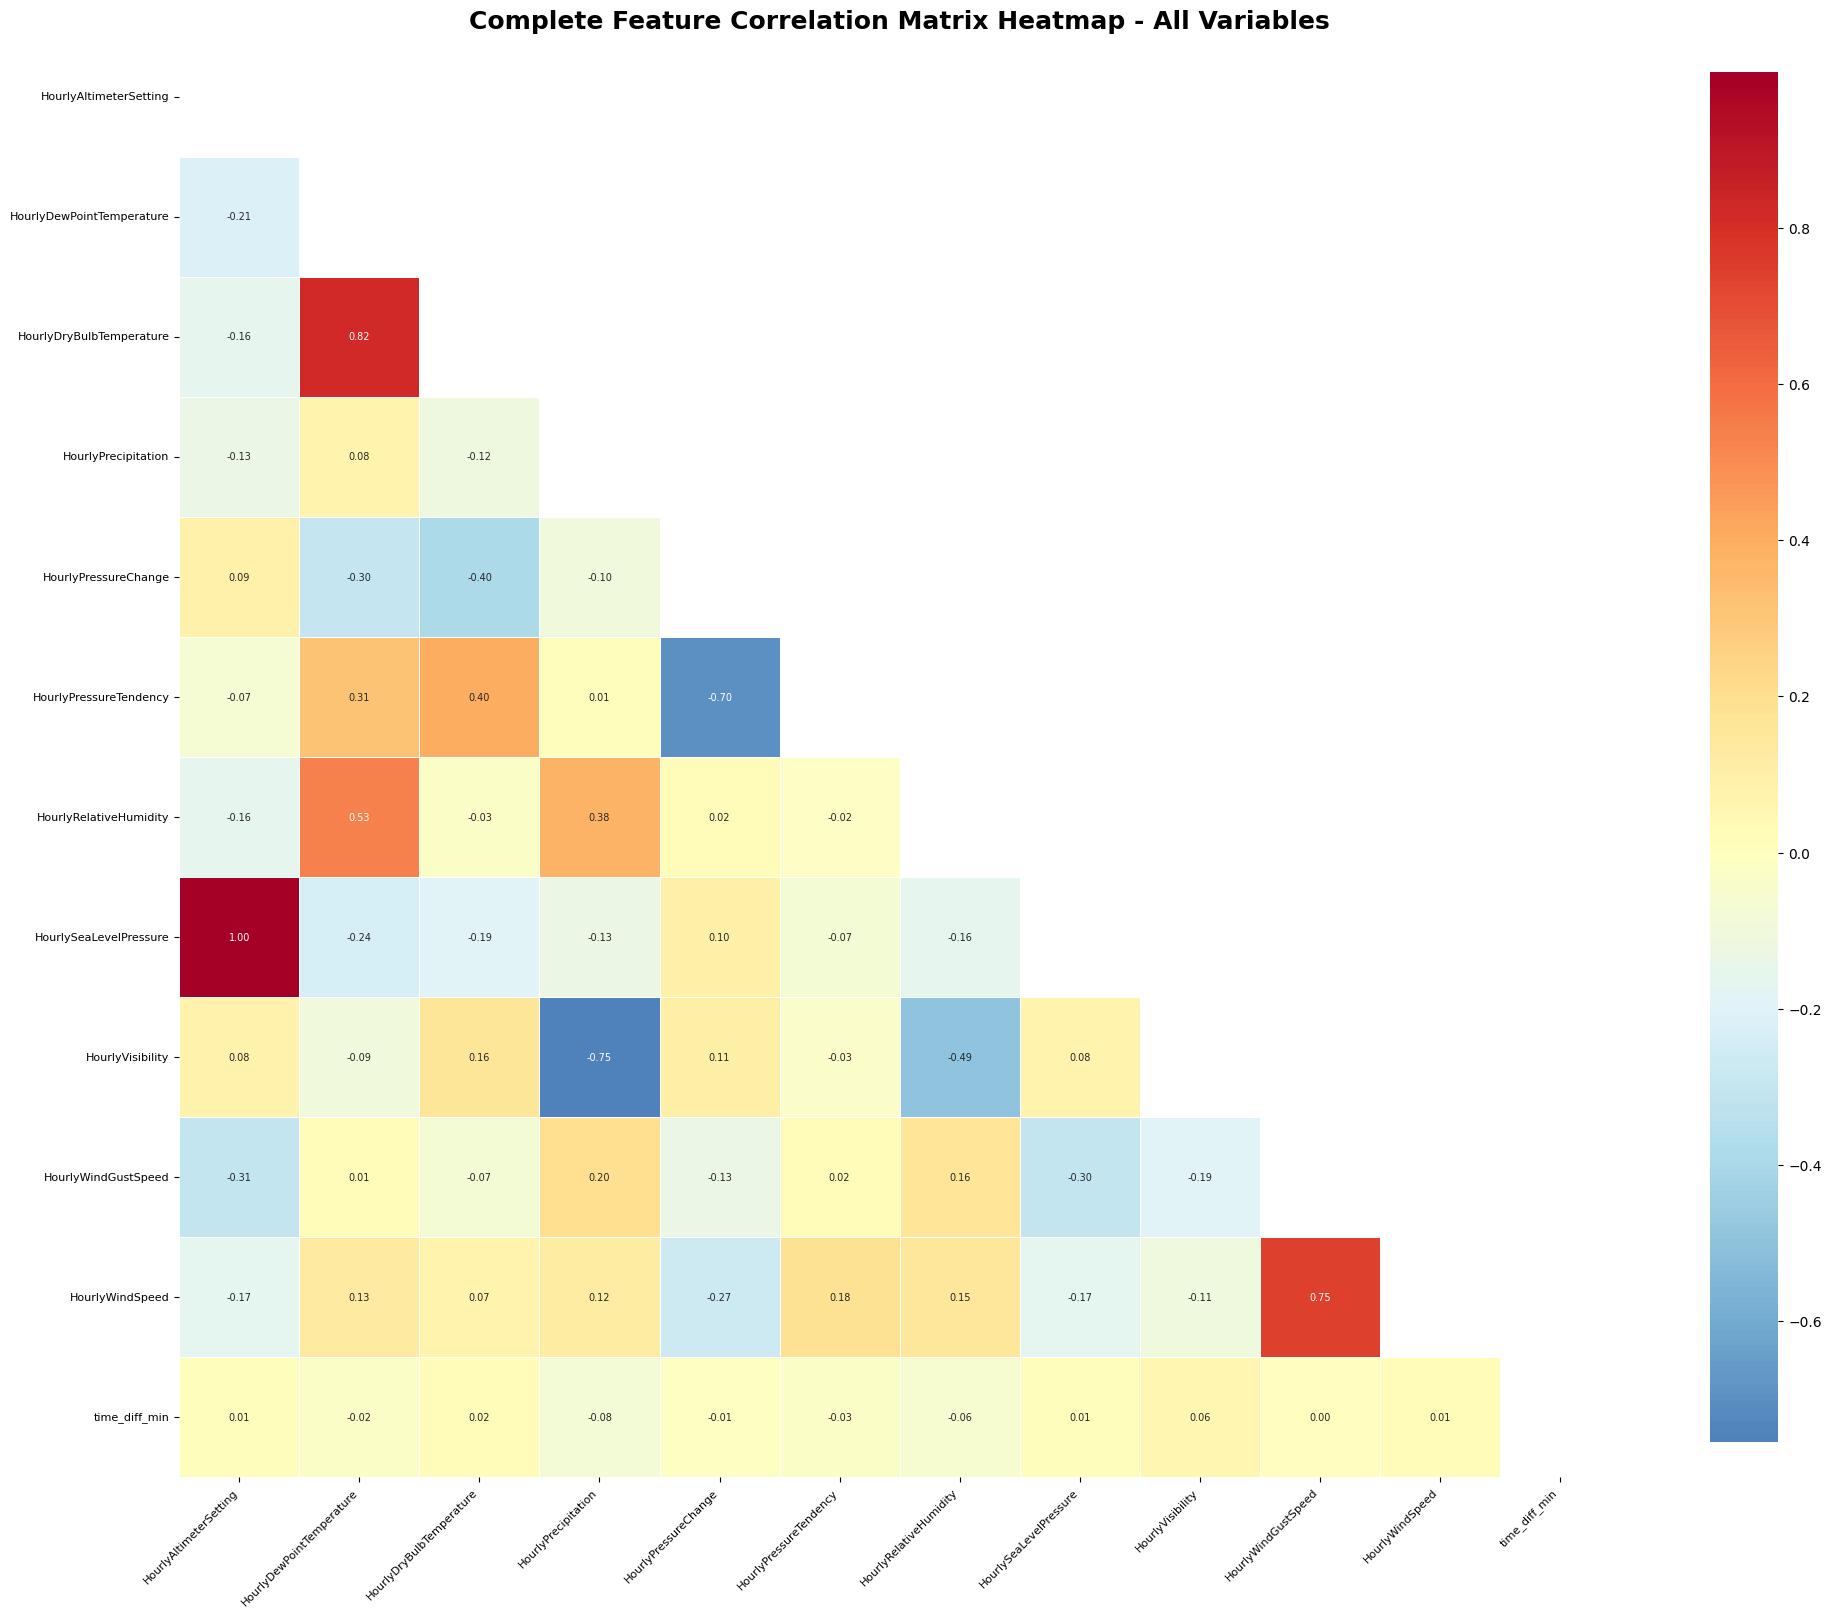


4.3 Complete Correlation Analysis with Flight Delay
Complete correlation of all features with flight delay (sorted by correlation):
 1. HourlyWindGustSpeed           : 0.0697
 2. HourlyRelativeHumidity        : 0.0440
 3. HourlyPressureChange          : 0.0259
 4. HourlyWindSpeed               : 0.0252
 5. HourlyDewPointTemperature     : 0.0150
 6. HourlyPrecipitation           : 0.0072
 7. time_diff_min                 : -0.0085
 8. HourlyVisibility              : -0.0085
 9. HourlyDryBulbTemperature      : -0.0107
10. HourlyPressureTendency        : -0.0269
11. HourlySeaLevelPressure        : -0.1049
12. HourlyAltimeterSetting        : -0.1051


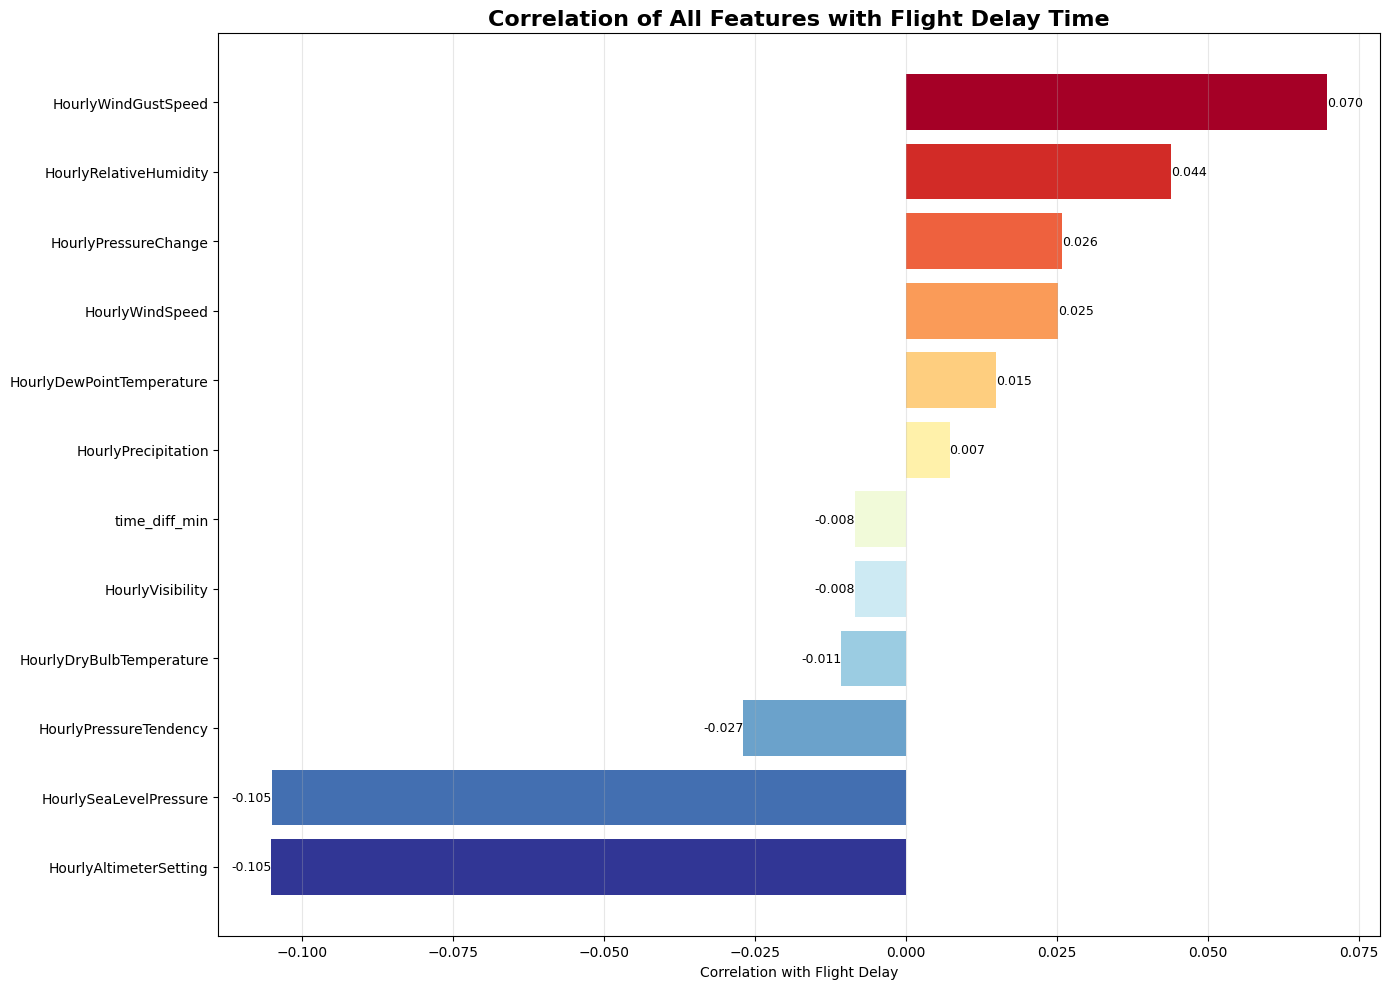

In [5]:

print("\nStep 4: Complete Multivariate Analysis and Correlation Analysis")

# 4.1 Complete Pairwise visualization - using all variables
print("4.1 Creating Complete Pairwise Relationships with All Variables")

# Create binary target variable for coloring (delayed vs not delayed)
y_binary = (y > 0).astype(int)  # 1 for delayed, 0 for on-time or early

# Since there are many variables, create a more compact PairGrid
print("Creating PairGrid visualization with all variables...")

# Select all variables for PairGrid analysis
pair_df = X_normalized_df.copy()
pair_df['Delay_Status'] = ['Delayed' if val == 1 else 'On Time/Early' for val in y_binary]

# Create PairGrid - using all variables
grid = sns.PairGrid(pair_df, hue='Delay_Status', corner=True, 
                    palette={'Delayed': 'red', 'On Time/Early': 'blue'},
                    diag_sharey=False)
grid.map_lower(sns.scatterplot, alpha=0.5, s=10)
grid.map_diag(sns.histplot, alpha=0.7, multiple="layer", element="step")
grid.add_legend(title='Flight Status', bbox_to_anchor=(0.5, 0.05), 
                loc='upper center', ncol=2)
plt.suptitle('Complete Pairwise Relationships Between All Variables Colored by Delay Status', 
             y=1.02, fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# 4.2 Complete correlation heatmap - all variables
print("\n4.2 Creating Complete Correlation Heatmap with All Variables")

# Calculate complete correlation matrix
corr_matrix = X_normalized_df.corr()

# Create upper triangle mask
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Plot correlation heatmap
plt.figure(figsize=(20, 18))
sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='RdYlBu_r',
            center=0, square=True, linewidths=0.5, 
            cbar_kws={"shrink": 0.8}, fmt='.2f',
            annot_kws={'size': 7})

plt.title('Complete Feature Correlation Matrix Heatmap - All Variables', 
          fontsize=18, fontweight='bold')
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.yticks(rotation=0, fontsize=8)
plt.tight_layout()
plt.show()

# 4.3 Complete correlation analysis with target variable
print("\n4.3 Complete Correlation Analysis with Flight Delay")

# Calculate correlation with target variable
delay_correlations = X_normalized_df.corrwith(y).sort_values(ascending=False)

print("Complete correlation of all features with flight delay (sorted by correlation):")
for i, (feature, corr) in enumerate(delay_correlations.items(), 1):
    print(f"{i:2d}. {feature:30s}: {corr:.4f}")

# Visualize correlation with target variable
plt.figure(figsize=(14, 10))
corr_with_delay = delay_correlations.sort_values(ascending=True)  # Sort ascending for horizontal bar chart

# Create horizontal bar chart
bars = plt.barh(range(len(corr_with_delay)), corr_with_delay.values, 
                color=plt.cm.RdYlBu_r(np.linspace(0, 1, len(corr_with_delay))))
plt.yticks(range(len(corr_with_delay)), corr_with_delay.index)
plt.xlabel('Correlation with Flight Delay')
plt.title('Correlation of All Features with Flight Delay Time', fontsize=16, fontweight='bold')
plt.grid(True, alpha=0.3, axis='x')

# Add value labels to bars
for i, bar in enumerate(bars):
    width = bar.get_width()
    plt.text(width, bar.get_y() + bar.get_height()/2, 
             f'{width:.3f}', ha='left' if width >= 0 else 'right', 
             va='center', fontsize=9)

plt.tight_layout()
plt.show()



**MODULE 5: Pre-regression Tests**


2. Statistical Significance Tests (F-tests)
HourlyAltimeterSetting: F-score=51.47, p-value=0.0000
HourlyDewPointTemperature: F-score=1.03, p-value=0.3100
HourlyDryBulbTemperature: F-score=0.53, p-value=0.4666
HourlyPrecipitation: F-score=0.24, p-value=0.6233
HourlyPressureChange: F-score=3.09, p-value=0.0789
HourlyPressureTendency: F-score=3.34, p-value=0.0677
HourlyRelativeHumidity: F-score=8.93, p-value=0.0028
HourlySeaLevelPressure: F-score=51.34, p-value=0.0000
HourlyVisibility: F-score=0.33, p-value=0.5643
HourlyWindGustSpeed: F-score=22.50, p-value=0.0000
HourlyWindSpeed: F-score=2.94, p-value=0.0866
time_diff_min: F-score=0.33, p-value=0.5649

Number of statistically significant features (p<0.05): 4

3. Multicollinearity Check (VIF)
Variance Inflation Factors:
                      Feature          VIF
8      HourlySeaLevelPressure  3378.428353
1      HourlyAltimeterSetting  3337.008346
2   HourlyDewPointTemperature   102.572049
3    HourlyDryBulbTemperature    73.531572
7     

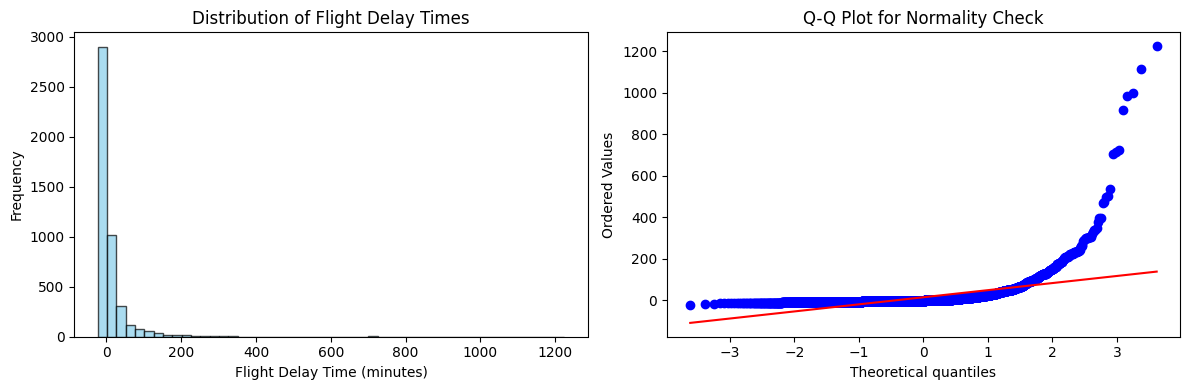

Shapiro-Wilk test (sample n=4613): statistic=0.3503, p-value=0.0000


In [6]:

print("\n2. Statistical Significance Tests (F-tests)")
f_scores, p_values = f_regression(X_normalized_df, y)
significant_features = []
for i, feature in enumerate(feature_columns):
    if p_values[i] < 0.05:
        significant_features.append(feature)
    print(f"{feature}: F-score={f_scores[i]:.2f}, p-value={p_values[i]:.4f}")

print(f"\nNumber of statistically significant features (p<0.05): {len(significant_features)}")

# Multicollinearity Check (VIF)
print("\n3. Multicollinearity Check (VIF)")
X_with_const = sm.add_constant(X_normalized_df)
vif_data = pd.DataFrame()
vif_data["Feature"] = X_with_const.columns
vif_data["VIF"] = [variance_inflation_factor(X_with_const.values, i) 
                   for i in range(X_with_const.shape[1])]
print("Variance Inflation Factors:")
print(vif_data.sort_values("VIF", ascending=False))

# Normality Test of Target Variable
print("\n4. Normality Test of Target Variable")
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(y, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
plt.xlabel('Flight Delay Time (minutes)')
plt.ylabel('Frequency')
plt.title('Distribution of Flight Delay Times')

plt.subplot(1, 2, 2)
stats.probplot(y, dist="norm", plot=plt)
plt.title('Q-Q Plot for Normality Check')

plt.tight_layout()
plt.show()

# Shapiro-Wilk test for normality (on sample due to large dataset)
sample_size = min(5000, len(y))
shapiro_stat, shapiro_p = shapiro(y.sample(sample_size, random_state=42))
print(f"Shapiro-Wilk test (sample n={sample_size}): statistic={shapiro_stat:.4f}, p-value={shapiro_p:.4f}")

**MODULE 5: Regression Modeling**


=== FEATURE SELECTION BEFORE DIMENSIONALITY REDUCTION ===
1. Selecting Statistically Significant Features (p < 0.05)
Selected 4 significant features:
  - HourlyAltimeterSetting
  - HourlySeaLevelPressure
  - HourlyWindGustSpeed
  - HourlyRelativeHumidity

Data dimensions after feature selection:
  Training set: (3690, 4)
  Test set: (923, 4)

2. Multicollinearity Check for Significant Features:


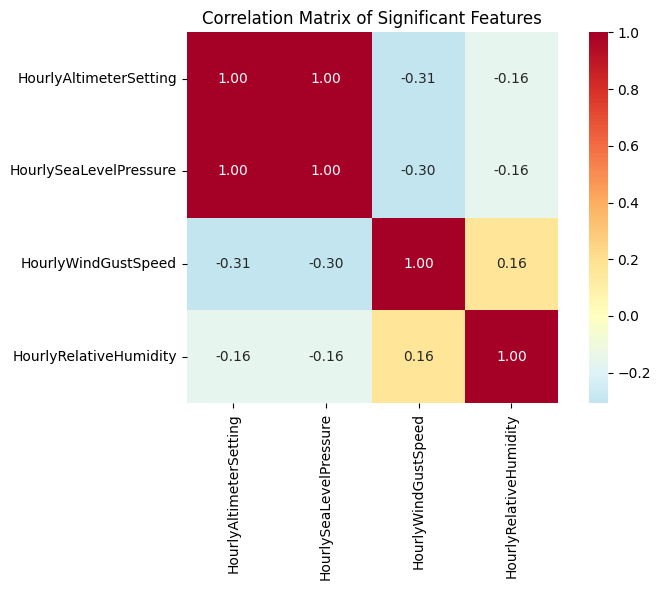

VIF for significant features:
                  Feature         VIF
1  HourlyAltimeterSetting  788.498132
2  HourlySeaLevelPressure  787.127360
3     HourlyWindGustSpeed    1.136005
4  HourlyRelativeHumidity    1.048922
0                   const    1.000000

3. Applying PCA on Significant Features

PCR Results with Significant Features Only:
   n_components      r2     rmse      mae  variance_explained
0             1  0.0075  66.7591  26.1435              0.5557
1             2  0.0078  66.7490  26.1099              0.8015
2             3  0.0073  66.7656  26.1198              0.9998
3             4  0.0073  66.7656  26.1189              1.0000

Optimal configuration:
  Components: 2
  R²: 0.0078
  Variance explained: 0.8015

4. Comparison: All Features vs Significant Features Only

Performance Comparison:
                     Approach  Number of Features  Optimal Components  \
0          All Features + PCA                  12                   4   
1  Significant Features + PCA      

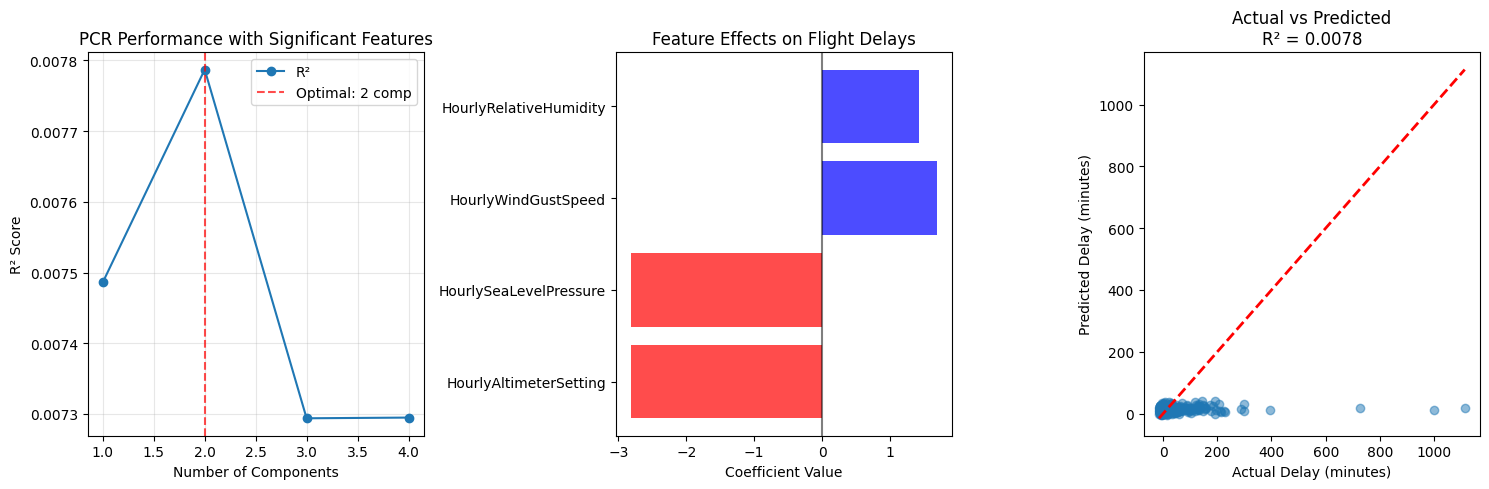

In [14]:
# =============================================================================
# Feature Selection Before Dimensionality Reduction
# =============================================================================
print("\n=== FEATURE SELECTION BEFORE DIMENSIONALITY REDUCTION ===")

# 1. Select only statistically significant features (p < 0.05)
print("1. Selecting Statistically Significant Features (p < 0.05)")

significant_features = [
    'HourlyAltimeterSetting',      # p=0.0000
    'HourlySeaLevelPressure',      # p=0.0000
    'HourlyWindGustSpeed',         # p=0.0000
    'HourlyRelativeHumidity',      # p=0.0028
]

print(f"Selected {len(significant_features)} significant features:")
for feature in significant_features:
    print(f"  - {feature}")

# 2. Prepare data with only significant features
X_sig = X_normalized_df[significant_features]
X_train_sig, X_test_sig, y_train_sig, y_test_sig = train_test_split(
    X_sig, y, test_size=0.2, random_state=42
)

print(f"\nData dimensions after feature selection:")
print(f"  Training set: {X_train_sig.shape}")
print(f"  Test set: {X_test_sig.shape}")

# 3. Check multicollinearity among significant features
print("\n2. Multicollinearity Check for Significant Features:")

# Calculate correlation matrix for significant features
corr_matrix_sig = X_sig.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix_sig, annot=True, cmap='RdYlBu_r', center=0, 
            square=True, fmt='.2f')
plt.title('Correlation Matrix of Significant Features')
plt.tight_layout()
plt.show()

# Check VIF for significant features
X_with_const = sm.add_constant(X_sig)
vif_data_sig = pd.DataFrame()
vif_data_sig["Feature"] = X_with_const.columns
vif_data_sig["VIF"] = [variance_inflation_factor(X_with_const.values, i) 
                       for i in range(X_with_const.shape[1])]

print("VIF for significant features:")
print(vif_data_sig.sort_values("VIF", ascending=False))

# 4. Apply PCA on significant features
print("\n3. Applying PCA on Significant Features")

# Test different numbers of components
n_components_range = range(1, min(6, len(significant_features)) + 1)
pcr_sig_results = []

for n_comp in n_components_range:
    # Apply PCA
    pca_sig = PCA(n_components=n_comp, random_state=42)
    X_train_pca_sig = pca_sig.fit_transform(X_train_sig)
    X_test_pca_sig = pca_sig.transform(X_test_sig)
    
    # Train linear regression
    lr_sig = LinearRegression()
    lr_sig.fit(X_train_pca_sig, y_train_sig)
    y_pred_sig = lr_sig.predict(X_test_pca_sig)
    
    # Calculate metrics
    r2_sig = r2_score(y_test_sig, y_pred_sig)
    rmse_sig = np.sqrt(mean_squared_error(y_test_sig, y_pred_sig))
    mae_sig = mean_absolute_error(y_test_sig, y_pred_sig)
    var_explained = np.sum(pca_sig.explained_variance_ratio_)
    
    pcr_sig_results.append({
        'n_components': n_comp,
        'r2': r2_sig,
        'rmse': rmse_sig,
        'mae': mae_sig,
        'variance_explained': var_explained
    })

# Create results DataFrame
pcr_sig_df = pd.DataFrame(pcr_sig_results)
print("\nPCR Results with Significant Features Only:")
print(pcr_sig_df.round(4))

# 5. Find optimal number of components
best_sig_idx = pcr_sig_df['r2'].idxmax()
best_sig_comp = pcr_sig_df.loc[best_sig_idx, 'n_components']
best_sig_r2 = pcr_sig_df.loc[best_sig_idx, 'r2']

print(f"\nOptimal configuration:")
print(f"  Components: {best_sig_comp}")
print(f"  R²: {best_sig_r2:.4f}")
print(f"  Variance explained: {pcr_sig_df.loc[best_sig_idx, 'variance_explained']:.4f}")

# 6. Compare with previous approach (all features + PCA)
print("\n4. Comparison: All Features vs Significant Features Only")

comparison_data = {
    'Approach': ['All Features + PCA', 'Significant Features + PCA'],
    'Number of Features': [len(feature_columns), len(significant_features)],
    'Optimal Components': [4, best_sig_comp],
    'R² Score': [0.0100, best_sig_r2],
    'Variance Explained': [0.7185, pcr_sig_df.loc[best_sig_idx, 'variance_explained']],
    'MAE': [26.20, pcr_sig_df.loc[best_sig_idx, 'mae']]
}

comparison_df = pd.DataFrame(comparison_data)
print("\nPerformance Comparison:")
print(comparison_df.round(4))

# 7. Train final model with optimal configuration
print(f"\n5. Training Final Model with {best_sig_comp} Components")

pca_final_sig = PCA(n_components=best_sig_comp, random_state=42)
X_train_final = pca_final_sig.fit_transform(X_train_sig)
X_test_final = pca_final_sig.transform(X_test_sig)

lr_final_sig = LinearRegression()
lr_final_sig.fit(X_train_final, y_train_sig)
y_pred_final = lr_final_sig.predict(X_test_final)

# Final performance
r2_final = r2_score(y_test_sig, y_pred_final)
mae_final = mean_absolute_error(y_test_sig, y_pred_final)
rmse_final = np.sqrt(mean_squared_error(y_test_sig, y_pred_final))

print(f"Final Model Performance:")
print(f"  R²: {r2_final:.4f}")
print(f"  MAE: {mae_final:.2f} minutes")
print(f"  RMSE: {rmse_final:.2f} minutes")

# 8. Model interpretation
print("\n6. Model Interpretation")

# Transform coefficients back to original feature space
pcr_coef_original = pca_final_sig.components_.T @ lr_final_sig.coef_

coef_analysis_sig = pd.DataFrame({
    'Feature': significant_features,
    'Coefficient': pcr_coef_original,
    'Absolute_Effect': np.abs(pcr_coef_original)
}).sort_values('Absolute_Effect', ascending=False)

print("Feature Effects in Final Model:")
for _, row in coef_analysis_sig.iterrows():
    direction = "increases" if row['Coefficient'] > 0 else "decreases"
    print(f"  {row['Feature']}: {direction} delay (effect: {abs(row['Coefficient']):.3f})")

# 9. Statistical significance of improvement
print("\n7. Statistical Significance Analysis")

# Compare with baseline (median predictor)
baseline_pred = np.full_like(y_test_sig, np.median(y_train_sig))
baseline_mae = mean_absolute_error(y_test_sig, baseline_pred)
baseline_r2 = r2_score(y_test_sig, baseline_pred)

improvement_mae = (baseline_mae - mae_final) / baseline_mae * 100
improvement_r2 = r2_final - baseline_r2

print(f"Baseline (median predictor):")
print(f"  R²: {baseline_r2:.4f}")
print(f"  MAE: {baseline_mae:.2f} minutes")

print(f"Model Improvement:")
print(f"  R² improvement: {improvement_r2:.4f}")
print(f"  MAE improvement: {improvement_mae:.1f}%")

# 10. Visualization of results
plt.figure(figsize=(15, 5))

# Performance vs number of components
plt.subplot(1, 3, 1)
plt.plot(pcr_sig_df['n_components'], pcr_sig_df['r2'], marker='o', label='R²')
plt.axvline(x=best_sig_comp, color='red', linestyle='--', alpha=0.7, 
            label=f'Optimal: {best_sig_comp} comp')
plt.xlabel('Number of Components')
plt.ylabel('R² Score')
plt.title('PCR Performance with Significant Features')
plt.legend()
plt.grid(True, alpha=0.3)

# Feature effects
plt.subplot(1, 3, 2)
colors = ['red' if x < 0 else 'blue' for x in coef_analysis_sig['Coefficient']]
plt.barh(coef_analysis_sig['Feature'], coef_analysis_sig['Coefficient'], 
         color=colors, alpha=0.7)
plt.axvline(x=0, color='black', linestyle='-', alpha=0.5)
plt.xlabel('Coefficient Value')
plt.title('Feature Effects on Flight Delays')

# Actual vs predicted
plt.subplot(1, 3, 3)
plt.scatter(y_test_sig, y_pred_final, alpha=0.5)
plt.plot([y_test_sig.min(), y_test_sig.max()], 
         [y_test_sig.min(), y_test_sig.max()], 'r--', lw=2)
plt.xlabel('Actual Delay (minutes)')
plt.ylabel('Predicted Delay (minutes)')
plt.title(f'Actual vs Predicted\nR² = {r2_final:.4f}')

plt.tight_layout()
plt.show()
